# REFL Assignment #2
# Cart-Pole
Vinodh Chincholi



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Helper Functions for Environment

In [2]:
def policy_function(state, weights):  # Sigmoid policy
    return 1 / (1 + np.exp(-(np.dot(weights, state))))

def simulate_dynamics(state, action):  # System dynamics
    g = 9.8  # Gravity
    cart_mass = 1.0  # Cart mass
    pole_mass = 0.1  # Pole mass
    force_magnitude = 10.0  # Force magnitude
    dt = 0.001  # Time step
    pole_length = 1.0  # Pole length
    x, x_dot, theta, theta_dot = state
    force = force_magnitude if action == 1 else -force_magnitude
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    theta_acc = (g * sin_theta + cos_theta * (-force - pole_mass * pole_length * theta_dot ** 2 * sin_theta) / (cart_mass + pole_mass)) / (
                pole_length * (4 / 3 - pole_mass * cos_theta ** 2 / (cart_mass + pole_mass)))
    x_acc = (force + pole_mass * pole_length * (theta_dot ** 2 * sin_theta - theta_acc * cos_theta)) / (cart_mass + pole_mass)
    x += dt * x_dot
    x_dot += dt * x_acc
    theta += dt * theta_dot
    theta_dot += dt * theta_acc
    return (x, x_dot, theta, theta_dot)

def execute_episode(weights):  # Run episode
    state = np.array([0, 0, 0, 0])
    total_reward = 0
    state_history = []
    action_history = []
    reward_history = []
    for _ in range(2000):
        state_history.append(state)
        action_prob = policy_function(state, weights)
        action = 1 if np.random.rand() < action_prob else 0
        action_history.append(action)
        next_state = simulate_dynamics(state, action)
        if abs(next_state[2]) > 5 * np.pi / 12 or abs(next_state[0]) > 3 or _ >= 2000:
            break
        reward_history.append(np.cos(next_state[2]))
        state = next_state
        total_reward += 1
    return state_history, action_history, reward_history

def value_func(state, coeffs):  # Linear value function
    return np.dot(state, coeffs)

In [4]:
def reinforce(num_episodes, learning_rate, delta_weights, discount_factor):
    weights = np.random.rand(4)
    episode_rewards = []
    for episode in range(num_episodes):
        states, actions, rewards = execute_episode(weights)
        total_episode_reward = sum(rewards)
        episode_rewards.append(total_episode_reward)
        grad_weights = np.zeros_like(weights)
        for t in range(len(states)):
            state = np.array(states[t])
            action = actions[t]
            policy_prob = policy_function(state, weights)
            G_t = sum(rewards[t:])
            grad_log_policy = (policy_function(state, weights) - policy_prob) * state
            grad_weights += (discount_factor ** t) * G_t * grad_log_policy
        weights += learning_rate * grad_weights
        if len(episode_rewards) > 1 and abs(episode_rewards[-1] - episode_rewards[-2]) < 0.1:
            print("REINFORCE converged at Episode", episode, "!")
            break
    return episode_rewards

def reinforce_with_baseline(num_episodes, alpha, beta, gamma, lamda, delta_theta, delta_w):
    theta = np.random.rand(4)
    w = np.random.rand(4)
    episode_rewards = []
    for episode in range(num_episodes):
        states, actions, rewards = execute_episode(theta)
        total_reward = sum(rewards)
        episode_rewards.append(total_reward)
        grad_theta = np.zeros_like(theta)
        eligibility_trace = np.zeros_like(w)
        for t in range(len(states)):
            state = np.array(states[t])
            action = actions[t]
            policy_prob = policy_function(state, theta)
            G_t = sum(rewards[t:])
            grad_log_policy = (policy_function(state, theta) - policy_prob) * state
            grad_theta += (gamma ** t) * G_t * grad_log_policy
            grad_v_w = (value_func(state, w + delta_w) - value_func(state, w)) / delta_w
            eligibility_trace = gamma * lamda * eligibility_trace + grad_v_w
        delta = G_t + gamma * value_func(states[-1], w) - value_func(states[0], w)
        w += alpha * delta * eligibility_trace
        theta += beta * grad_theta
        if len(episode_rewards) > 1 and abs(episode_rewards[-1] - episode_rewards[-2]) < 0.001:
            print("Baseline REINFORCE converged at Episode", episode, "!")
            break
    return episode_rewards

In [5]:
# Hyperparameters
num_episodes = 1000
learning_rate = 0.1
beta = 0.1
gamma = 0.9
lamda = 0.9
delta_theta = 0.001
delta_w = 0.001

# Run REINFORCE algorithm
reinforce_rewards = reinforce(num_episodes, learning_rate, delta_theta, gamma)

# Run Baseline REINFORCE algorithm
baseline_rewards = reinforce_with_baseline(num_episodes, learning_rate, beta, gamma, lamda, delta_theta, delta_w)


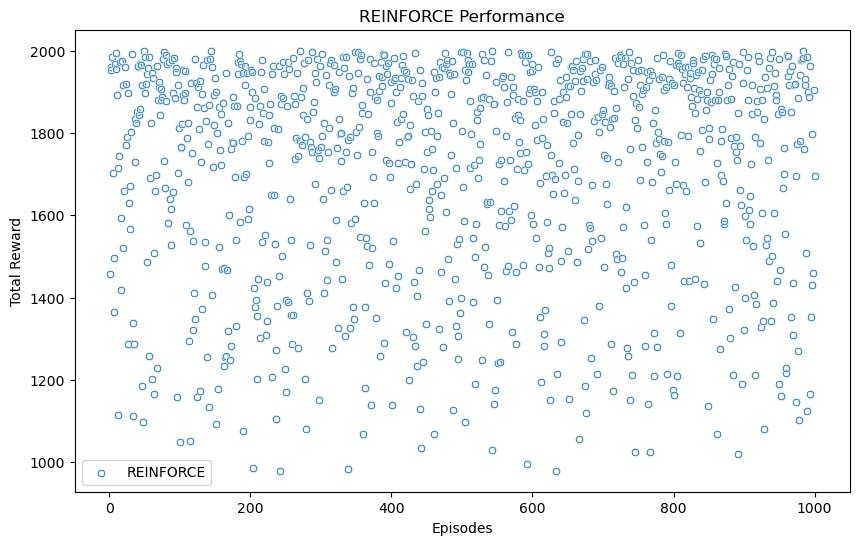

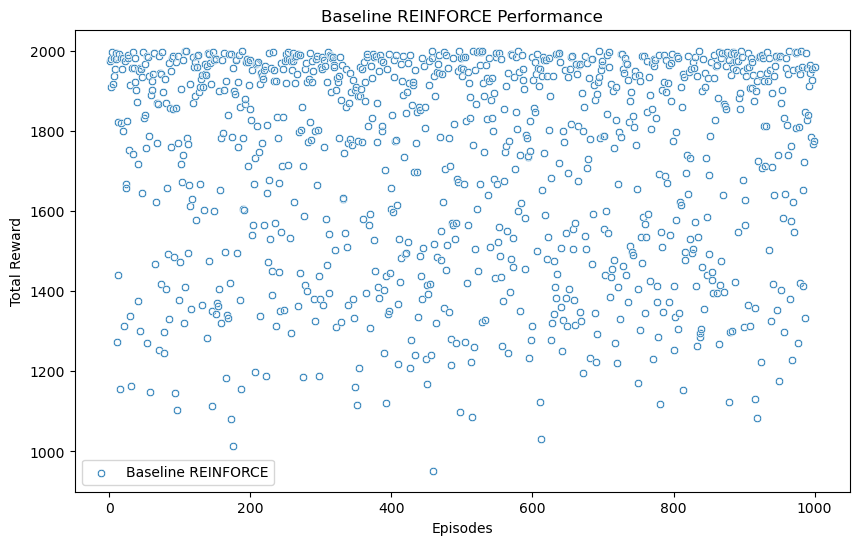

In [26]:
title_reinforce = "REINFORCE"
title_baseline = "Baseline REINFORCE"

# Calculate mean and standard deviation
episodes_reinforce = range(1, len(reinforce_rewards) + 1)
mean_reinforce = np.mean(reinforce_rewards)
std_reinforce = np.std(reinforce_rewards)

episodes_baseline = range(1, len(baseline_rewards) + 1)
mean_baseline = np.mean(baseline_rewards)
std_baseline = np.std(baseline_rewards)

data_reinforce = pd.DataFrame({
    'Episodes': episodes_reinforce,
    'Total Reward': reinforce_rewards,
    'Standard Deviation': [std_reinforce] * len(episodes_reinforce),
    'Algorithm': [title_reinforce] * len(episodes_reinforce)
})

data_baseline = pd.DataFrame({
    'Episodes': episodes_baseline,
    'Total Reward': baseline_rewards,
    'Standard Deviation': [std_baseline] * len(episodes_baseline),
    'Algorithm': [title_baseline] * len(episodes_baseline)
})

# Plot 1: REINFORCE Performance
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Episodes', 
    y='Total Reward', 
    data=data_reinforce, 
    label=title_reinforce,
    marker='$\circ$'
)
# plt.errorbar(data_reinforce['Episodes'], data_reinforce['Total Reward'], yerr=data_reinforce['Standard Deviation'], fmt='o', color='orange', ecolor='orange', elinewidth=2, capsize=4)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('REINFORCE Performance')
plt.legend()
plt.show()

# Plot 2: Baseline REINFORCE Performance
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Episodes', 
    y='Total Reward', 
    data=data_baseline, 
    label=title_baseline,
    marker='$\circ$'
)
# plt.errorbar(data_baseline['Episodes'], data_baseline['Total Reward'], yerr=data_baseline['Standard Deviation'], fmt='o', color='orange', ecolor='orange', elinewidth=0.5, capsize=1)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Baseline REINFORCE Performance')
plt.legend()
plt.show()

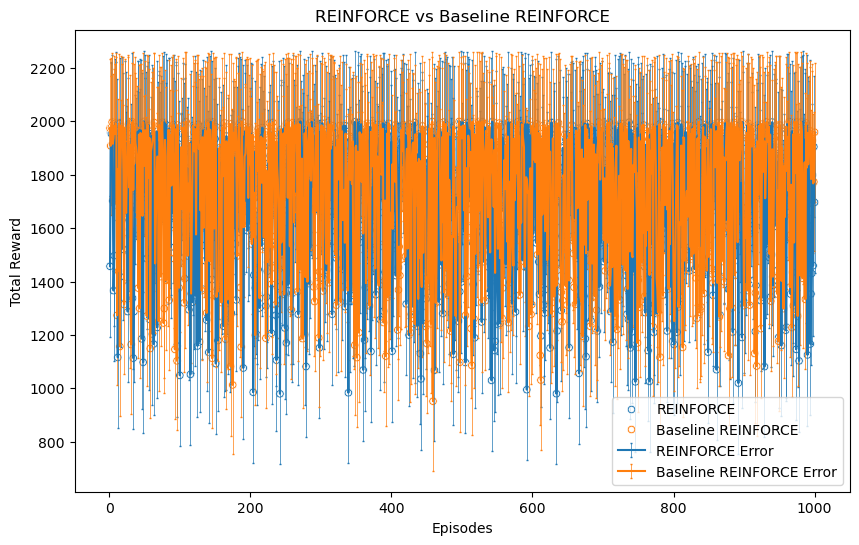

In [28]:
data_combined = pd.concat([data_reinforce, data_baseline])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Episodes', 
    y='Total Reward', 
    hue='Algorithm', 
    data=data_combined, 
    marker='$\circ$'
)

# Add error bars for both algorithms
for alg in [title_reinforce, title_baseline]:
    subset = data_combined[data_combined['Algorithm'] == alg]
    plt.errorbar(subset['Episodes'], subset['Total Reward'], yerr=subset['Standard Deviation'], fmt='', label=f'{alg} Error', elinewidth=0.5, capsize=0.5)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('REINFORCE vs Baseline REINFORCE')
plt.legend()
plt.show()

Both algorithms perform similarly for Cart Pole as well but there is no clear convergence here.